In [ ]:
#default_exp noisyimagenette

In [ ]:
#hide
# !pip install -Uq nbdev
# !pip install -Uq fastcore
# !pip install -Uq fastai

In [ ]:
#export
from fastcore.test import *
from fastai.vision.all import *
from pathlib import Path

import pandas as pd
import fastai, fastcore, nbdev
test_eq(['2.3.0', '1.3.19', '1.1.13'], [fastai.__version__, fastcore.__version__, nbdev.__version__])

In [ ]:
source = untar_data(URLs.IMAGENETTE)

In [ ]:
csv_file: pd.DataFrame = pd.read_csv(source/'noisy_imagenette.csv')

In [ ]:
test_eq(13394, len(csv_file))

In [ ]:
expected = ['path', 'noisy_labels_0', 'noisy_labels_1', 'noisy_labels_5', 'noisy_labels_25', 'noisy_labels_50', 'is_valid']

test_eq(expected, list(csv_file.columns))

In [ ]:
test_eq(3925, len(csv_file[csv_file['is_valid'] == True]))

In [ ]:
sample = dict(
    is_valid=False,
    noisy_labels_0='n02979186',
    noisy_labels_1='n02979186',
    noisy_labels_25='n02979186',
    noisy_labels_5='n02979186',
    noisy_labels_50='n02979186',
    path='train/n02979186/n02979186_9036.JPEG')

test_eq(sample, dict(csv_file.iloc[0]))

In [ ]:

lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
def label_func(fname):
  return lbl_dict[parent_label(fname)]

In [ ]:
def get_dls(file, noice_pct):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('path', pref=source),
                   get_y=Pipeline([ColReader(f'noisy_labels_{noice_pct}'), lbl_dict.__getitem__]),
                   splitter=ColSplitter(),
                   item_tfms=[RandomResizedCrop(128, min_scale=0.35), FlipItem(0.5)],
                   batch_tfms=Normalize.from_stats(*imagenet_stats))
  dls = dblock.dataloaders(file)
  return dls

In [ ]:
set_seed(42, reproducible=True)

## 5 noice percent

In [ ]:
dls_5 = get_dls(csv_file, 5)

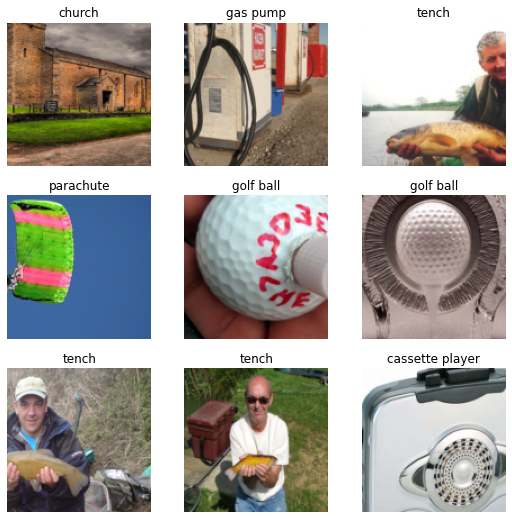

In [ ]:
dls_5.show_batch()

In [ ]:
learn_5 = cnn_learner(dls_5, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.001737800776027143)

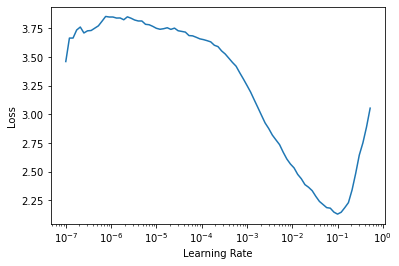

In [ ]:
learn_5.lr_find()

In [ ]:
learn_5.fine_tune(epochs=3, base_lr=1e-3, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy,time
0,1.446703,0.420198,0.876943,01:21
1,0.847860,0.226991,0.933503,01:22
2,0.741666,0.207286,0.934522,01:22
3,0.668340,0.186720,0.947771,01:22
4,0.605991,0.193323,0.946497,01:22


epoch,train_loss,valid_loss,accuracy,time
0,0.554958,0.169319,0.951847,01:24
1,0.467919,0.138371,0.959745,01:24
2,0.378111,0.144780,0.960255,01:25


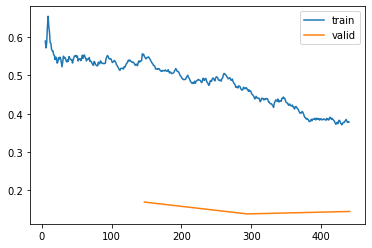

In [ ]:
learn_5.recorder.plot_loss()

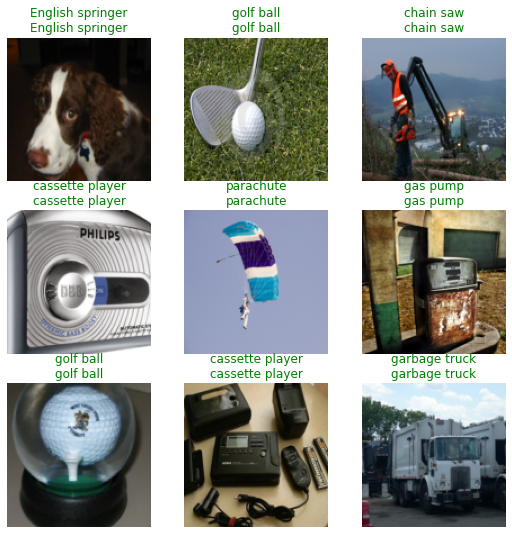

In [ ]:
learn_5.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_5)
interp.most_confused()

[('gas pump', 'garbage truck', 16),
 ('chain saw', 'French horn', 10),
 ('French horn', 'chain saw', 9),
 ('cassette player', 'gas pump', 6),
 ('chain saw', 'garbage truck', 6),
 ('chain saw', 'parachute', 6),
 ('cassette player', 'chain saw', 5),
 ('gas pump', 'chain saw', 5),
 ('gas pump', 'church', 5),
 ('chain saw', 'gas pump', 4),
 ('chain saw', 'tench', 4),
 ('golf ball', 'chain saw', 4),
 ('parachute', 'chain saw', 4),
 ('tench', 'chain saw', 4),
 ('cassette player', 'French horn', 3),
 ('church', 'golf ball', 3),
 ('church', 'parachute', 3),
 ('gas pump', 'cassette player', 3),
 ('golf ball', 'tench', 3),
 ('parachute', 'church', 3),
 ('English springer', 'chain saw', 2),
 ('English springer', 'parachute', 2),
 ('French horn', 'cassette player', 2),
 ('French horn', 'church', 2),
 ('French horn', 'gas pump', 2),
 ('French horn', 'golf ball', 2),
 ('French horn', 'tench', 2),
 ('cassette player', 'garbage truck', 2),
 ('chain saw', 'golf ball', 2),
 ('garbage truck', 'church', 2

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
interp.plot_top_losses??

In [ ]:
top_k, idxs = interp.top_losses(k=5)

In [ ]:
idxs

TensorBase([3871, 3768,  145, 1891, 2973])

In [ ]:
dls_5.train_ds[3871]

(PILImage mode=RGB size=500x357, TensorCategory(0))

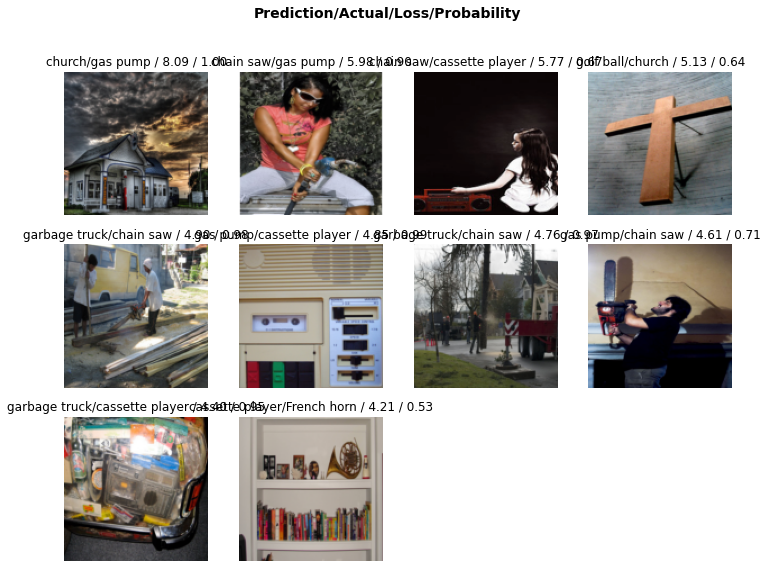

In [ ]:
interp.plot_top_losses(k=10)

## 25 noice percent 

Here the validation set will not contain any incorrect labels.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('path', pref=source),
                   get_y=Pipeline([ColReader(f'noisy_labels_25'), lbl_dict.__getitem__]),
                   splitter=ColSplitter(),
                   item_tfms=[RandomResizedCrop(128, min_scale=0.35), FlipItem(0.5)],
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

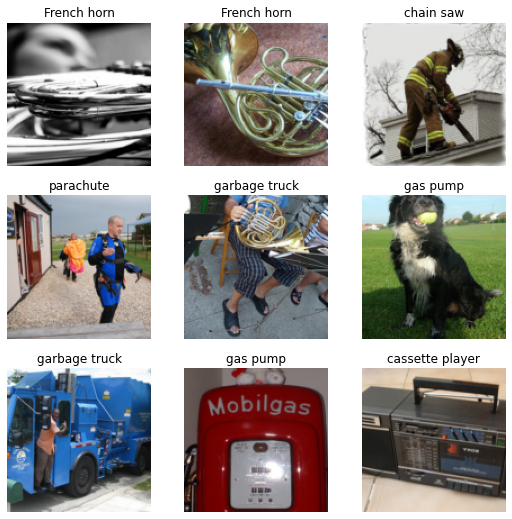

In [ ]:
dls = dblock.dataloaders(csv_file)
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


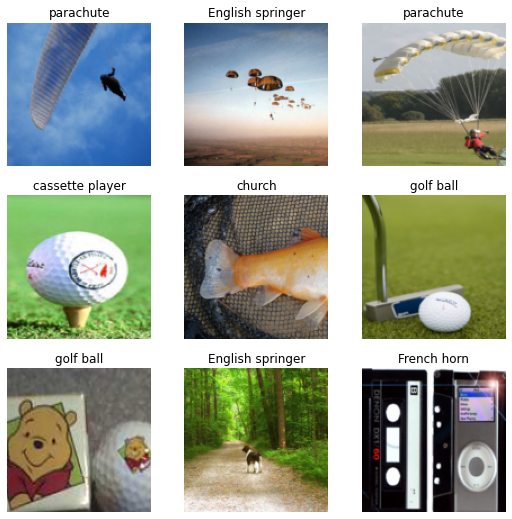

In [ ]:
dls.train.show_batch()

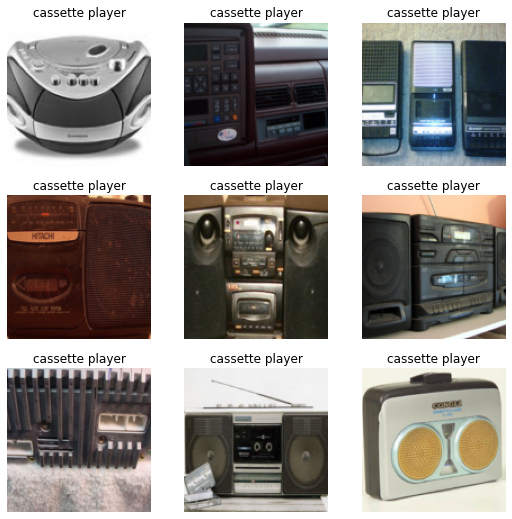

In [ ]:
dls.valid.show_batch()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0030199517495930195)

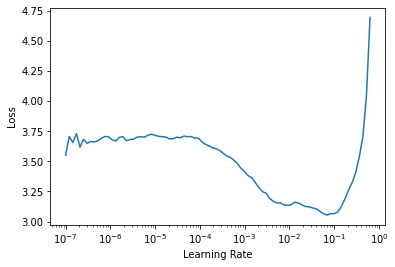

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.948211,0.512535,0.884586,01:23
1,1.547888,0.450991,0.930446,01:23
2,1.387833,0.473935,0.940382,01:22
3,1.295599,0.385814,0.949554,01:22
4,1.197416,0.409498,0.951083,01:22


In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=1.5848931980144698e-06)

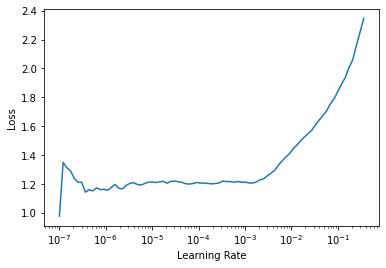

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.220114,0.427654,0.949299,01:25
1,1.220826,0.433591,0.949045,01:25
2,1.101860,0.394963,0.951592,01:25


Even though our dataset has 25% incorrect labels present, we still managed to achieve 95% accuracy.

## 50 noise percent

In [ ]:
dls_50 = get_dls(csv_file, 50)

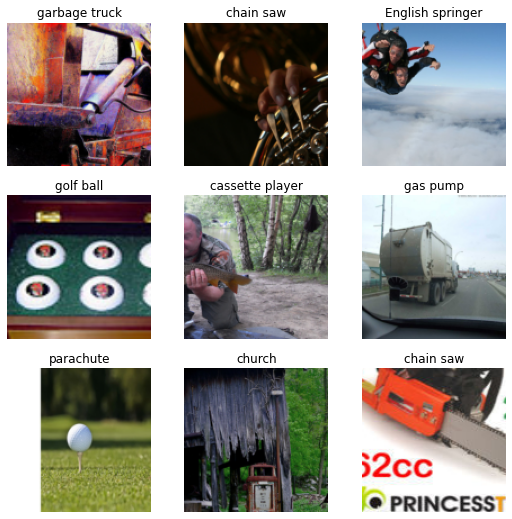

In [ ]:
dls_50.show_batch()

In [ ]:
learn_50 = cnn_learner(dls_50, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0006918309954926372)

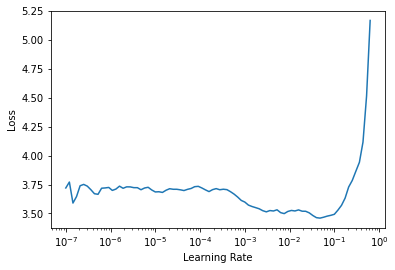

In [ ]:
learn_50.lr_find()

In [ ]:
learn_50.fine_tune(epochs=3, freeze_epochs=5, base_lr=4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.908580,0.790149,0.817070,01:22
1,2.523659,0.874419,0.825478,01:23
2,2.199923,0.897595,0.868535,01:22
3,2.071265,0.914389,0.871083,01:24
4,2.049342,0.862465,0.900892,01:22


epoch,train_loss,valid_loss,accuracy,time
0,1.985508,0.979482,0.849936,01:25
1,1.905314,0.852328,0.909045,01:25
2,1.723611,0.827393,0.912866,01:24


With dataset having 50% incorrect labels present, we still managed to achieve 91% accuracy.

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_noisyimagenette.ipynb.
Converted index.ipynb.
